In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
import tensorflow.python.util.deprecation as deprecation
import pathlib
deprecation._PRINT_DEPRECATION_WARNINGS = False
%matplotlib inline



### Set up tokens to download data from kaggle via api

To download manually got to https://www.kaggle.com/shayanfazeli/heartbeat

To run the below cell, enter valid user name and api key

To install kaggle run 'pip install kaggle'

In [34]:
import os
os.environ['KAGGLE_USERNAME'] = "jinujayan"
os.environ['KAGGLE_KEY'] = "799d2b77ddfbafa78c6eae8b1f681e3a"
import kaggle
kaggle.api.authenticate()

pathlib.Path.cwd().joinpath('data').mkdir(parents=True, exist_ok=True)
kaggle.api.dataset_download_files('shayanfazeli/heartbeat', path='data', unzip=True)

### Read the MIT Arrhythmia Dataset

In [35]:
df = pd.read_csv('data/mitbih_train.csv')
renamed_cols = [f"col_{i}" for i,col in enumerate(df.columns)]
df.columns = renamed_cols

df_test = pd.read_csv('data/mitbih_test.csv')
renamed_cols = [f"col_{i}" for i,col in enumerate(df_test.columns)]
df_test.columns = renamed_cols

df_MIT = pd.concat([df,df_test],ignore_index=True)
df_MIT.shape

(109444, 188)

### Data Visualization and Analysis

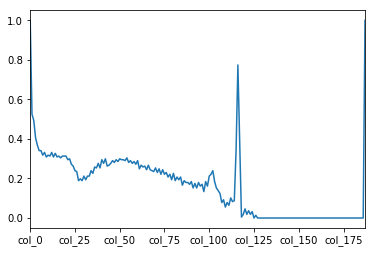

In [36]:
###Plot to see variations in each class
##change class numbers as 1.0, 0.0, 2.0,3.0, 4.0

def plotGivenClass(cls):
    df_MIT.loc[df_MIT.col_187 == cls].sample(1).iloc[0].plot()
    return

plotGivenClass(1.0)

In [57]:
df_MIT.col_187.value_counts()

0.0    90587
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: col_187, dtype: int64

### Split dataset to train and test

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df_MIT.iloc[:,:-1].values, df_MIT.iloc[:,-1].values, test_size = 0.3, random_state = 42)

### Create model architecture - ECG Classifier

In [38]:
num_classes=5
model_m = Sequential()
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(187,1)))

model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(160, 10, activation='relu'))

model_m.add(MaxPooling1D(2))
model_m.add(Dropout(0.5))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 178, 100)          1100      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 89, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 160)           160160    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 40, 160)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 160)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [39]:
### Format the data so as to get it to correct shape
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#x_train = x_train.shape + (1,)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

In [40]:
y_test.shape

(32834, 5)

In [41]:
## Start model training...can be skipped and model directly loaded

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 500
EPOCHS = 10

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      shuffle=True,
                      callbacks=callbacks_list,
                      #validation_split=0.25,
                      validation_data=(x_test, y_test),
                      verbose=1)

Train on 76610 samples, validate on 32834 samples
Epoch 1/10
76610/76610 [==============================] - 174s 2ms/step - loss: 0.4480 - acc: 0.8744 - val_loss: 0.2759 - val_acc: 0.9297
Epoch 2/10
76610/76610 [==============================] - 176s 2ms/step - loss: 0.2360 - acc: 0.9346 - val_loss: 0.2098 - val_acc: 0.9411
Epoch 3/10
76610/76610 [==============================] - 192s 3ms/step - loss: 0.1936 - acc: 0.9463 - val_loss: 0.1709 - val_acc: 0.9524
Epoch 4/10
76610/76610 [==============================] - 200s 3ms/step - loss: 0.1687 - acc: 0.9537 - val_loss: 0.1509 - val_acc: 0.9575
Epoch 5/10
76610/76610 [==============================] - 216s 3ms/step - loss: 0.1519 - acc: 0.9586 - val_loss: 0.1350 - val_acc: 0.9623
Epoch 6/10
76610/76610 [==============================] - 200s 3ms/step - loss: 0.1380 - acc: 0.9615 - val_loss: 0.1248 - val_acc: 0.9660
Epoch 7/10
76610/76610 [==============================] - 218s 3ms/step - loss: 0.1285 - acc: 0.9646 - val_loss: 0.1154 - 

In [42]:
###Save the ECG classifier model to disk
model_m.save("models/model_ECG_final.h5")

## Visualize Heartbeat classifier model loss and accuracy trends from training

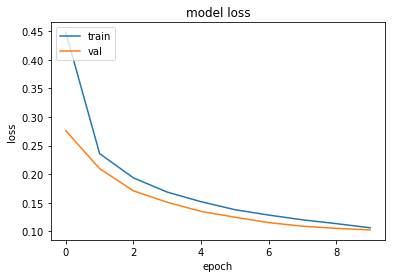

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

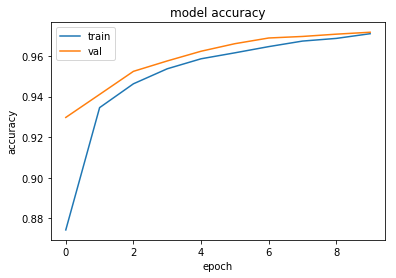

In [44]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
##View model weights
model_m.weights

[<tf.Variable 'conv1d_5/kernel:0' shape=(10, 1, 100) dtype=float32_ref>,
 <tf.Variable 'conv1d_5/bias:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'conv1d_6/kernel:0' shape=(10, 100, 160) dtype=float32_ref>,
 <tf.Variable 'conv1d_6/bias:0' shape=(160,) dtype=float32_ref>,
 <tf.Variable 'dense_3/kernel:0' shape=(6400, 5) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(5,) dtype=float32_ref>]

In [46]:
###Test some data points

model_loaded = load_model('models/model_ECG_final.h5')
idx = [26,27]

##if previously not resphaped, run below line also
#to_pred = x_test[idx].reshape(1,x_test[idx].shape[0], x_test[idx].shape[1])

#if previously reshaped run the below line, else comment
to_pred = x_test[idx]
out_classes = model_loaded.predict(to_pred)
print(f"The actual class for the test indexes are {np.argmax(y_test[idx],axis=1)}")
print(f"The predicted classes for the test indexes are {np.argmax(out_classes, axis =1)}")


The actual class for the test indexes are [0 0]
The predicted classes for the test indexes are [0 0]


In [47]:
model_loaded.layers

In [48]:
def copyModel2Model(model_source,model_target,certain_layer=""):
    """
    Function to copy weights from one model to another model till a certain layer
    
    @param  model_source : The source model whose weight needs to be copied
    @param  model_target : The target model whose weight needs to be updated
    @param  certain_layer : The layer till which the weights to be updated in the target model
    
    @return 
    """
    for l_tg,l_sr in zip(model_target.layers,model_source.layers):
        print(l_tg.name)
        wk0=l_sr.get_weights()
        l_tg.set_weights(wk0)
        if certain_layer in l_tg.name:
            default_layer = l_tg.name
            break
    print(f"Weights from model source was copied into model target...till layer {default_layer}(excluded)") 
    return


### Read the PTB Diagnostic ECG Dataset

In [49]:
df_ptbn = pd.read_csv('data/ptbdb_normal.csv')
renamed_cols = [f"col_{i}" for i,col in enumerate(df_ptbn.columns)]
df_ptbn.columns = renamed_cols

df_ptbabn = pd.read_csv('data/ptbdb_abnormal.csv')
renamed_cols = [f"col_{i}" for i,col in enumerate(df_ptbabn.columns)]
df_ptbabn.columns = renamed_cols

df_ptb = pd.concat([df_ptbn,df_ptbabn],ignore_index=True)

### Split dataset to train and test

In [50]:
xmi_train, xmi_test, ymi_train, ymi_test = train_test_split(df_ptb.iloc[:,:-1].values, df_ptb.iloc[:,-1].values, test_size = 0.3, random_state = 42)

In [51]:
##Format data to expected shape
ymi_train = to_categorical(ymi_train)
ymi_test = to_categorical(ymi_test)
xmi_train = xmi_train.reshape(xmi_train.shape[0], xmi_train.shape[1],1)
xmi_test = xmi_test.reshape(xmi_test.shape[0], xmi_test.shape[1],1)
xmi_test.shape

(4365, 187, 1)

### Create model architecture - MI classifier

In [52]:
xmi_train.shape

(10185, 187, 1)

In [53]:
num_classes=2
model_mi = Sequential()

model_mi.add(Conv1D(100, 10, activation='relu', input_shape=(187,1)))
model_mi.add(MaxPooling1D(2))
model_mi.add(Conv1D(160, 10, activation='relu'))

model_mi.add(MaxPooling1D(2))
model_mi.add(Dropout(0.5))
model_mi.add(Flatten())
model_mi.add(Dense(num_classes, activation='softmax'))
print(model_mi.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 178, 100)          1100      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 89, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 80, 160)           160160    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 40, 160)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 160)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [54]:
model_mi.layers

In [55]:
### Call the method to initialize the weights of the model_mi
copyModel2Model(model_loaded,model_mi,"flatten")

conv1d_7
max_pooling1d_7
conv1d_8
max_pooling1d_8
dropout_4
flatten_4
Weights from model source was copied into model target...till layer flatten_4(excluded)


In [61]:
### Verify if model weights are correctly copied

source_layer1_weights = model_loaded.layers[0].get_weights()
source_layer1_weights = np.array(source_layer1_weights[0])

target_layer1_weights = model_mi.layers[0].get_weights()
target_layer1_weights = np.array(target_layer1_weights[0])

print(f"Comparisson results of the two model weights compared is -> {np.allclose(source_layer1_weights, target_layer1_weights)}")

Comparisson results of the two model weights compared is -> True


In [62]:
## Start training of the MI classifier with initialized weights.

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_MI_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_mi.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 250
EPOCHS = 10

history = model_mi.fit(xmi_train,
                      ymi_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      shuffle=True,
                      callbacks=callbacks_list,
                      #validation_split=0.2,
                      validation_data=(xmi_test, ymi_test),
                      verbose=1)

Train on 10185 samples, validate on 4365 samples
Epoch 1/10
10185/10185 [==============================] - 32s 3ms/step - loss: 0.4429 - acc: 0.7833 - val_loss: 0.3474 - val_acc: 0.8504
Epoch 2/10
10185/10185 [==============================] - 33s 3ms/step - loss: 0.3373 - acc: 0.8483 - val_loss: 0.2963 - val_acc: 0.8857
Epoch 3/10
10185/10185 [==============================] - 25s 2ms/step - loss: 0.2943 - acc: 0.8734 - val_loss: 0.2613 - val_acc: 0.8960
Epoch 4/10
10185/10185 [==============================] - 25s 2ms/step - loss: 0.2605 - acc: 0.8919 - val_loss: 0.2479 - val_acc: 0.8962
Epoch 5/10
10185/10185 [==============================] - 25s 2ms/step - loss: 0.2469 - acc: 0.8950 - val_loss: 0.2287 - val_acc: 0.9113
Epoch 6/10
10185/10185 [==============================] - 24s 2ms/step - loss: 0.2135 - acc: 0.9130 - val_loss: 0.1939 - val_acc: 0.9278
Epoch 7/10
10185/10185 [==============================] - 25s 2ms/step - loss: 0.1953 - acc: 0.9221 - val_loss: 0.1742 - val_acc:

## Visualize model training metrics

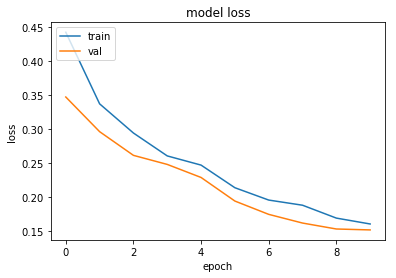

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

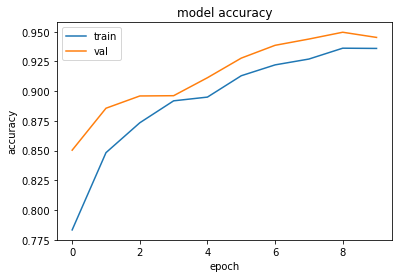

In [64]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save the trained model MI classifier

In [65]:
model_mi.save("models/model_MI_final.h5")

### Evaluate model predictions

In [66]:
idx = [8,9,10, 3500]
ymi_test[idx]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [67]:
###Test some data points
model_MI_loaded = load_model('models/model_MI_final.h5')
idx = [8,9,10, 3500]

##if previously not resphaped, run below line also
#to_pred = x_test[idx].reshape(1,x_test[idx].shape[0], x_test[idx].shape[1])

#if previously reshaped run the below line, else comment
to_pred = xmi_test[idx]
out_classes = model_MI_loaded.predict(to_pred)
MI_class = np.argmax(out_classes,axis=1)

print(f"The actual class for the test indexes are {np.argmax(ymi_test[idx],axis=1)}")
print(f"The predicted classes for the test indexes are {np.argmax(out_classes, axis =1)}")

The actual class for the test indexes are [1 1 1 0]
The predicted classes for the test indexes are [1 1 1 0]


## Final Comments

As the data was already in format ready to be used for training there was not much of preprocessing required.

The data can be visually analyzed by plotting the readings to see some pattern emerging for the 5 heartbeat classes.

There was not a lot of variations in accuracy seen for hyperparameters changes like Batch size, optimizer.

It was noticed an accuracy improvement of 4% with the transfer learning approach as compared to the training of MI classifier from random weighs initialization.